In [ ]:
import pandas as pd
import numpy as np
import numpy.random as nrand
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

warnings.filterwarnings('ignore')

In [ ]:
# Set matplotlib parameters for consistent styling
rcParams_dict = {
    'xtick.bottom': True,
    'patch.edgecolor':'k',
    'patch.force_edgecolor': True,
    'font.size': 15,
    'pdf.fonttype':42,
    'font.family':'Arial',
    'mathtext.fontset':'custom',
    'mathtext.default': 'regular',
    'mathtext.it': 'Arial:italic',
    'mathtext.it': 'Arial:italic',
}
mpl.rcParams.update(rcParams_dict)

In [ ]:
# Load phenotype data
df_phe = pd.read_table('/home/siliang/Public/workspace/4_UKB_merged_files/GWAS/GWAS_adj_extended.phe')
df_phe = df_phe[['IID','N_full_brothers','N_full_sisters']]

# Load sample data and merge with phenotype data
sam_df = pd.read_table(f'/home/siliang/Public/workspace/UKB_imp_filtered_SR_RAP/chr1.psam')
target_IID = sam_df['IID']
df_phe = pd.merge(right=df_phe,left=target_IID,on='IID')

# Calculate total number of siblings and family members
df_phe['N_siblings'] = df_phe['N_full_brothers'] + df_phe['N_full_sisters']

In [ ]:
# Function to get true positive rate (TPR) for a given beta and MAF
def get_TPR(beta, MAF, SR_WT=0.52, N_rep=1000, scale=1):
    SR_1M = SR_WT + beta
    SR_2M = SR_WT + 2*beta

    N_Ps = len(df_phe) * scale # Total number of participants in simulation
    N_sib_Tot = df_phe['N_siblings'].sum() * scale # Total number of siblings in simulation

    N_Ps_1M = int(N_Ps * 2*(1-MAF)*MAF) # Number of participants carrying one copy of mutant allele
    N_Ps_2M = int(N_Ps * MAF**2) # Number of participants carrying two copy of mutant allele
    N_Ps_WT = N_Ps - N_Ps_1M - N_Ps_2M  # Number of participants with wildtype genotype.

    res_dict = {
        'P':[],
        't':[],
        'SE':[],
        'BETA':[]
    }
    
    for i in range(N_rep):
        
        # Here we only consider the genetic effect of one side of parents (either paternal or maternal).
        # Number of cases where 
        # participant is WT and the participant's father/mother is WT (N_Ps_WT_Parent_WT)
        # participant is WT and the participant's father/mother is 1M (N_Ps_WT_Parent_1M)
        N_Ps_WT_Parent_WT, N_Ps_WT_Parent_1M= \
            nrand.multinomial(N_Ps_WT,[1-MAF, MAF])

        # Number of cases where 
        # participant is 1M and the participant's father/mother is WT (N_Ps_1M_Parent_WT)
        # participant is 1M and the participant's father/mother is 1M (N_Ps_1M_Parent_1M)
        # participant is 1M and the participant's father/mother is 2M (N_Ps_1M_Parent_2M)
        N_Ps_1M_Parent_WT, N_Ps_1M_Parent_1M, N_Ps_1M_Parent_2M = \
            nrand.multinomial(N_Ps_1M ,[0.5*(1-MAF), 0.5, 0.5*MAF])

        # Number of cases where 
        # participant is 2M and the participant's father/mother is 1M (N_Ps_2M_Parent_1M)
        # participant is 2M and the participant's father/mother is 2M (N_Ps_2M_Parent_2M)
        N_Ps_2M_Parent_1M, N_Ps_2M_Parent_2M= \
            nrand.multinomial(N_Ps_2M,[1-MAF, MAF])

        # Sample number of siblings for each of participant-parent genotype combination
        N_Ps_WT_Parent_WT_sib, N_Ps_WT_Parent_1M_sib,N_Ps_1M_Parent_WT_sib, \
        N_Ps_1M_Parent_1M_sib, N_Ps_1M_Parent_2M_sib,N_Ps_2M_Parent_1M_sib, \
        N_Ps_2M_Parent_2M_sib = nrand.multinomial(
            N_sib_Tot,
            np.array([N_Ps_WT_Parent_WT, N_Ps_WT_Parent_1M,N_Ps_1M_Parent_WT,
                      N_Ps_1M_Parent_1M, N_Ps_1M_Parent_2M,N_Ps_2M_Parent_1M,
                      N_Ps_2M_Parent_2M])/N_Ps
        )
        
        # Calculate number of siblings for each participant's genotype
        N_Ps_WT_sib = N_Ps_WT_Parent_WT_sib + N_Ps_WT_Parent_1M_sib
        N_Ps_1M_sib = N_Ps_1M_Parent_WT_sib + N_Ps_1M_Parent_1M_sib + N_Ps_1M_Parent_2M_sib
        N_Ps_2M_sib = N_Ps_2M_Parent_1M_sib + N_Ps_2M_Parent_2M_sib

        # Sample number of brothers and sisters for WT, 1M, and 2M.
        N_Ps_WT_bro = nrand.binomial(N_Ps_WT_Parent_WT_sib,SR_WT) + nrand.binomial(N_Ps_WT_Parent_1M_sib,SR_1M)
        N_Ps_WT_sis = N_Ps_WT_sib - N_Ps_WT_bro

        N_Ps_1M_bro = nrand.binomial(N_Ps_1M_Parent_WT_sib,SR_WT) + nrand.binomial(N_Ps_1M_Parent_1M_sib,SR_1M) + \
                      nrand.binomial(N_Ps_1M_Parent_2M_sib,SR_2M)
        N_Ps_1M_sis = N_Ps_1M_sib - N_Ps_1M_bro

        N_Ps_2M_bro = nrand.binomial(N_Ps_2M_Parent_1M_sib,SR_1M) + nrand.binomial(N_Ps_2M_Parent_2M_sib,SR_2M)
        N_Ps_2M_sis = N_Ps_2M_sib - N_Ps_2M_bro

        # Weighted Least Square Regression, equivalent to logistic regression.
        X = np.array([0,1,2]).reshape(-1,1)
        X = sm.add_constant(X)
        Y = np.array([N_Ps_WT_bro/N_Ps_WT_sib, N_Ps_1M_bro/N_Ps_1M_sib, N_Ps_2M_bro/N_Ps_2M_sib]).reshape(-1,1)
        Y[np.isnan(Y)] = 0 # avoid the problem of dividing 0.
        
        glm = sm.GLM(
            Y,
            X,
            family=sm.families.Binomial(),
            freq_weights=[N_Ps_WT_sib, N_Ps_1M_sib, N_Ps_2M_sib]
        )
        
        res = glm.fit()

        res_dict['P'].append(res.pvalues[1])
        res_dict['t'].append(res.tvalues[1])
        res_dict['SE'].append(res.bse[1])
        res_dict['BETA'].append(res.params[1])
    
    # Calculate true positive rate.
    TPR = (np.array(res_dict['P']) < 5e-8).sum()/len(res_dict['P'])
    return TPR

In [ ]:
# Parameters for simulation
SR_WT = 0.52
N_rep = 1000
beta_list = np.linspace(start=0.005,stop=0.2,num=40)
MAF_list = np.linspace(start=0.0025,stop=0.1,num=40)

# Initialize result array
TPR_res_array = np.zeros(shape=[len(beta_list),len(MAF_list)])

# Run simulation for each combination of beta and MAF
for i,beta in enumerate(beta_list):
    print(f'beta: {beta}')
    for j,MAF in enumerate(MAF_list):
        print(f'MAF: {MAF}', flush=True, end='\r')
        # Adjust the scale (1, 2, 4, 8) to simulate different samples size.
        # scale=1 means using the same sample size as the UKB.
        TPR_res_array[i,j] = get_TPR(beta, MAF, SR_WT, N_rep, scale=1)
        if TPR_res_array[i,j] == 1:
            TPR_res_array[i,j:] = 1
            break

In [ ]:
# Save the results
with open('TPR_res_array_UKB_logistic_1X.pkl','wb') as f:
    pickle.dump(TPR_res_array,f)

Text(53.222222222222214, 0.5, '$\\mathit{β}$')

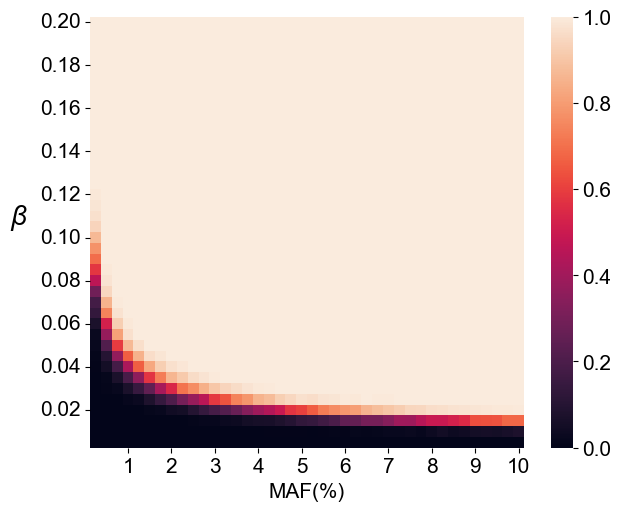

In [4]:
# Plot the results
fig,ax = plt.subplots(figsize=[7,5.6])
ax2 = sns.heatmap(TPR_res_array)
ax.set_xticks(ticks=np.linspace(3,39,10)+0.5,
              labels=[f'{MAF*100:.0f}' for MAF in np.linspace(start=0.01,stop=0.1,num=10)],rotation=0,fontsize=15)
ax.set_yticks(ticks=np.linspace(3,39,10)+0.5,
              labels=[f'{beta:.2f}' for beta in np.linspace(start=0.02,stop=0.2,num=10)],rotation=0,fontsize=15)
ax.invert_yaxis()

cbar = ax2.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)

ax.set_xlabel('MAF(%)',fontsize=15)
ax.set_ylabel('$\mathit{β}$',fontsize=20,rotation=0,labelpad=15)

plt.savefig('UKB_power_analysis_logistic_1X.pdf')